In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import shapely.wkt
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv('C:/Users/BillyErmlick/Desktop/Workspace/school/DAEN/Exploration/artifacts/polygons.csv')
df['image_name'] = df['image_name'].apply(lambda x: str(x))

In [3]:
images = df.image_name.unique()


In [4]:
df['xy'] = df['polygon_x_y'].apply( lambda x : shapely.wkt.loads(x))
df['ll'] = df['polygon_lng_lat'].apply( lambda x : shapely.wkt.loads(x))

In [24]:
#filter by first image #.str.contains('og', regex=False)
disasterimages = df[df['image_name'].str.contains('santa-rosa-wildfire_00000161_post_disaster.png', regex=False)]
imagelist = disasterimages.image_name.unique()

In [25]:
imagelist

array(['santa-rosa-wildfire_00000161_post_disaster.png'], dtype=object)

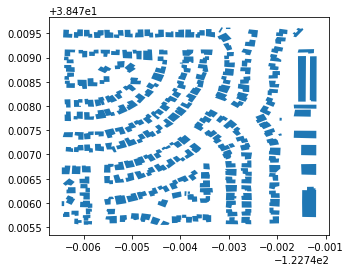

In [26]:
lonlat = gpd.GeoDataFrame(disasterimages, geometry='ll') 
wkt = gpd.GeoDataFrame(disasterimages, geometry='xy') 
lonlat.plot()

In [49]:
imageloclist = []
lonlat = gpd.GeoDataFrame(disasterimages, geometry='ll') 

for image in imagelist:
    x = []
    y = []
    for element in lonlat[lonlat['image_name'].str.contains(image, regex=False)]['xy']:
        x.extend(element.exterior.coords.xy[0])
        y.extend(element.exterior.coords.xy[1]) 
    xll = []
    yll = []
    for element in lonlat[lonlat['image_name'].str.contains(image, regex=False)]['ll']:
        xll.extend(element.exterior.coords.xy[0])
        yll.extend(element.exterior.coords.xy[1])
        
    longpixelrate= abs((max(xll)-min(xll))/(max(x)-min(x)))   #change in long per x pixel
    latpixelrate= abs((max(yll)-min(yll))/(min(y)-max(y)))   #change in long per x pixel
    nwlatitudeofimage = max(yll) + min(y)*latpixelrate #asumes all iamges taken level to longitude lines and xy labeled from NW corner with +y beingin the -lat direction and +x in +lon diection
    nwlongitudeofimage = min(xll) -min(x)*longpixelrate #asumes all iamges taken level to longitude lines and xy labeled from NW corner with +y beingin the -lat direction and +x in +lon diection
    selatitudeofimage = nwlatitudeofimage + 1024*longpixelrate
    selongitudefoimage = nwlongitudeofimage +1024*longpixelrate
    width = 1024*longpixelrate #vary based on resolution
    height = 1024*latpixelrate #vary based on resolution
    imageloclist.append([str(image), nwlatitudeofimage, nwlongitudeofimage,swlatitudeofimage,swlongitudefoimage])
imagelocdf=pd.DataFrame(imageloclist,columns=['image','NWlat', 'NWlon', 'SElat', 'SElon'])
    

In [50]:
imagelocdf.head()

,image,NWlat,NWlon,SElat,SElon
0,santa-rosa-wildfire_00000161_post_disaster.png,38.479673,-122.746452,38.484943,-122.741182


In [401]:
#equal values in theory-> 
max(x), max(xll)
min(x), min(xll)

min(y), max(yll)
max(y), min(yll)

(1022.983427738279, 38.48390378007404)

# Work on doing financial analysis on single image obtained from model

## 1) first try based on pixel analysis

In [89]:
from PIL import Image
import numpy as np
import mgrs
m = mgrs.MGRS()
NWlat = imagelocdf['NWlat'].values[0]
NWlon = imagelocdf['NWlon'].values[0]
SElat = imagelocdf['SElat'].values[0]
SElon = imagelocdf['SElon'].values[0]
longpixelrate
latpixelrate

4.034684520236036e-06

In [66]:
im = np.array(Image.open('../../xview2unet/santa/test_damage_disaster_prediction.png'))

In [67]:
im.shape

(1024, 1024)

In [68]:
# Image.fromarray(im)
np.unique(im)

array([  0,  63, 126, 189, 252], dtype=uint8)

In [75]:
lons = []
for i, pix in enumerate(im[0,:]):
    lons.append(NWlon + i*longpixelrate)
lats = []
for i, pix in enumerate(im[:,0]):
    lats.append(NWlat + i*latpixelrate)
mgrsgrids = pd.DataFrame()
i=0
for r in range(0, im.shape[0]):
    for c in range(0, im.shape[1]):
#         if r % 10 == 0 and c % 10 == 0: #every 10 pixels?
        mgrsgrids[r,c] = m.toMGRS(lats[r], lons[c]).decode()
        i+=1
        print(i)
          
#this EXPLODES.... maybe someone can figure something else out but I'm not taking that approach for now - even parallel would take forever

## 2) try polygon approach as we did before

In [ ]:
from PIL import Image
import numpy as np
import mgrs
m = mgrs.MGRS()
NWlat = imagelocdf['NWlat'].values[0]
NWlon = imagelocdf['NWlon'].values[0]
SElat = imagelocdf['SElat'].values[0]
SElon = imagelocdf['SElon'].values[0]
longpixelrate
latpixelrate
NWlat
im = np.array(Image.open('../../xview2unet/santa/test_damage_disaster_prediction.png'))

In [ ]:
np.unique(im)

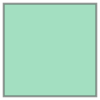

In [153]:
#get image polygon
from shapely.geometry import Point, Polygon, MultiPolygon
import shapely.ops as ops
from functools import partial
import pyproj 
latlons = [Point(NWlat,NWlon),
            Point(NWlat,SElon),
            Point(SElat,SElon),
            Point(SElat,NWlon)]
poly = Polygon([(p.y, p.x) for p in latlons]) #lon, lat
poly

In [154]:
geom=poly

geom_area = ops.transform(
partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'), #https://gis.stackexchange.com/questions/127607/area-in-km-from-polygon-of-coordinates
    pyproj.Proj(
        proj='aea',
        lat_1=geom.bounds[1],
        lat_2=geom.bounds[3])),
geom)

print(np.sqrt(geom_area.area))
# lengthfeet= np.sqrt(geom_area.area) * 3.28084

518.6380184346369


In [155]:
lons = []
for i, pix in enumerate(im[0,:]):
    lons.append(NWlon + i*longpixelrate)
lats = []
for i, pix in enumerate(im[:,0]):
    lats.append(NWlat + i*latpixelrate)

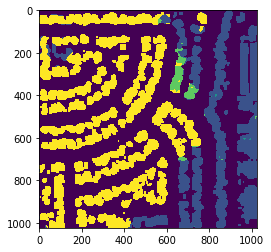

In [157]:
import cv2
from collections import defaultdict
img_file = '../../xview2unet/santa/test_damage_disaster_prediction.png'
img_plt = plt.imread(img_file)
plt.imshow(img_plt)
img_cv2 = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
plt.imshow(img_cv2)

In [507]:
def split(contours, ki = 0.25, ks = 0.05, areamin=25000):
    contours_new = []
    for contour in contours:
        dists = []
        count = len(contour)
        wegotabigone = False
        print(cv2.contourArea(contour))
        if cv2.contourArea(contour) > 10000: #if it's a big polygon
            wegotabigone = True 
            print('TRUE')
        
        #print(dists)
        if wegotabigone:
            a = round(count*.5)
            b = round(count)
            old = contour.copy()
            new = old[a:b]
            old1 = old[0:a]
            old2 = old[b:len(old)]
            old = np.concatenate((old1,old2))
            contours_new.append(old)
            contours_new.append(new)
            print(cv2.contourArea(new))
            print(cv2.contourArea(old))
        else:
            contours_new.append(contour)

    print('OLD: {} - NEW: {}'.format(len(contours),len(contours_new)))
    return contours_new

In [508]:
#to polygons
def mask_to_polygons(mask, epsilon=10., min_area=10.):
    """Convert a mask ndarray (binarized image) to Multipolygons"""
    # first, find contours with cv2: it's much faster than shapely
    contours, hierarchy = cv2.findContours(mask,
                                  cv2.RETR_CCOMP,
                                  cv2.CHAIN_APPROX_NONE)
    if not contours:
        return MultiPolygon()
    
#     for i in range(5):
#         contours = split(contours, areamin=min_area)
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    all_polygons = MultiPolygon(all_polygons)

    return all_polygons

In [509]:
img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)

In [510]:
BW = cv2.convertScaleAbs(img)

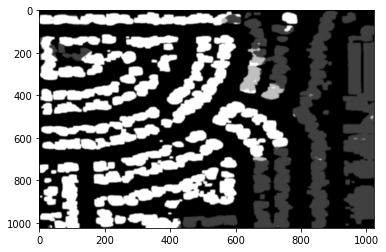

In [511]:
plt.imshow(BW, cmap='gray', interpolation='bicubic',aspect='auto')

In [512]:
polygons = mask_to_polygons(BW, min_area=500)

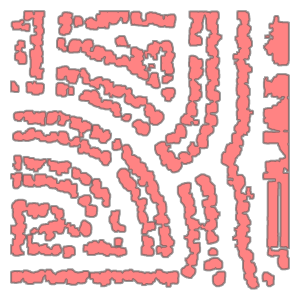

In [513]:
polygons

In [515]:
kernel = np.ones(shape=(5, 5),
                 dtype=np.uint8)
image= cv2.dilate(img_file,
                  kernel=kernel)

TypeError: Expected Ptr<cv::UMat> for argument '%s'